In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

### MLL Results

In [3]:
path = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]
mll = {}
for i, unc_job in enumerate(job_dirs):
    mll['unc' + str(i)] = pd.read_csv(path + 'mll/nuc_conc/train/' + unc_job + '/' + unc_job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [4]:
rxtr_mll = []
burn_mll = []
enri_mll = []
cool_mll = []
rxtr_mll_std = []
burn_mll_std = []
enri_mll_std = []
cool_mll_std = []
for i, unc_job in enumerate(uncs):
    key = 'unc' + str(i)
    rxtr_mll.append(mll[key]['ReactorType_Score'].mean())
    rxtr_mll_std.append(mll[key]['ReactorType_Score'].std())
    burn_mll.append(-mll['unc'+str(i)]['Burnup_Error'].mean())
    burn_mll_std.append(mll['unc'+str(i)]['Burnup_Error'].std())
    enri_mll.append(-mll['unc'+str(i)]['Enrichment_Error'].mean())
    enri_mll_std.append(mll['unc'+str(i)]['Enrichment_Error'].std())
    cool_mll.append(-mll['unc'+str(i)]['CoolingTime_Error'].mean())
    cool_mll_std.append(mll['unc'+str(i)]['CoolingTime_Error'].std())

### Scikit Results

In [6]:
learn_path = 'scikit/nuc_conc/rand_err/'
csv_end = '_nuc29_random_error.csv'
frac = '1.0'
rxtr_knn = pd.read_csv(path + learn_path + 'reactor_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
rxtr_dtr = pd.read_csv(path + learn_path + 'reactor_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')
burn_knn = pd.read_csv(path + learn_path + 'burnup_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
burn_dtr = pd.read_csv(path + learn_path + 'burnup_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')
enri_knn = pd.read_csv(path + learn_path + 'enrichment_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
enri_dtr = pd.read_csv(path + learn_path + 'enrichment_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')
cool_knn = pd.read_csv(path + learn_path + 'cooling_knn_tset' + frac + csv_end).drop(columns='Unnamed: 0')
cool_dtr = pd.read_csv(path + learn_path + 'cooling_dtree_tset' + frac + csv_end).drop(columns='Unnamed: 0')

# Plotting

In [70]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [64]:
def plot_curves(title): 
    plt.clf()    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)   
    ax.set_title(title, fontsize=20, pad=15)
    
    sv_base = 'plots/randerr_compare_nuc29'
    
    err_type = 'MAE'
    mae_axlbl = 'Negative ' + err_type
    if 'Burnup' in title:
        mll = burn_mll
        std = burn_mll_std
        knn = -1*burn_knn
        dtr = -1*burn_dtr
        axlbl = mae_axlbl + ' [MWd/MTU]'
        sv_fig = sv_base + '_burn.png'
    elif 'Reactor' in title:
        err_type = 'Acc'
        mll = rxtr_mll
        std = rxtr_mll_std
        knn = rxtr_knn
        dtr = rxtr_dtr
        axlbl = 'Accuracy Score'
        sv_fig = sv_base + '_rxtr.png'
    elif 'Enrichment' in title:
        mll = enri_mll
        std = enri_mll_std
        knn = -1*enri_knn
        dtr = -1*enri_dtr
        axlbl = mae_axlbl + ' [% U235]'
        sv_fig = sv_base + '_enri.png'
    else:
        mll = cool_mll
        std = cool_mll_std
        knn = -1*cool_knn
        dtr = -1*cool_dtr
        axlbl = mae_axlbl + ' [days]'
        sv_fig = sv_base + '_cool.png'
    knn_err = 'kNN ' + err_type
    dtr_err = 'DTree ' + err_type
    knn_std = 'kNN ' + err_type + ' Std'
    dtr_std = 'DTree ' + err_type + ' Std'
    ax.set_xlabel('Percent Error', fontsize=20, labelpad=15)
    ax.set_ylabel(axlbl, fontsize=20, labelpad=15)
    
    ## Scikit Results
    err = burn_knn['Percent Error']
    ax.fill_between(err, knn[knn_err] - knn[knn_std], knn[knn_err] + knn[knn_std], color=colors['DBrwn'], alpha=0.3)
    ax.fill_between(err, dtr[dtr_err] - dtr[dtr_std], dtr[dtr_err] + dtr[dtr_std], color=colors['DTeal'], alpha=0.3)
    ax.plot(err, knn[knn_err], 'o-', color=colors['MBrwn'], mew=0, ms=5, label='kNN')
    ax.plot(err, dtr[dtr_err], 'o-', color=colors['MTeal'], mew=0, ms=5, label='Dec Tree')
    
    ## MLL Results
    unc = [100*x for x in uncs]
    mll = np.array(mll)
    std = np.array(std)
    ax.plot(unc, mll, 'o-', color=colors['MPurp'], mew=0, ms=5, label='MLL Calc')
    ax.fill_between(unc, mll - std, mll + std, color=colors['MPurp'], alpha=0.3)
    
    ax.tick_params(labelsize=14)
    #h,l = ax.get_legend_handles_labels()
    #handles = [h[0], h[2], h[4], h[1], h[3], h[5], h[6]]
    #labels = [l[0], l[2], l[4], l[1], l[3], l[5], l[6]]
    #ax.legend(handles,labels,loc='best')
    ax.legend(loc='lower left')
    
    if 'Reactor' in title:
        ax.set_ylim(0.83, 1.01)
    elif 'Burnup' in title:
        ax.set_ylim(-1200, 30)
    elif 'Enrichment' in title:
        ax.set_ylim(-0.17, 0.009)
    else:
        ax.set_ylim(-550, 10)
    plt.show()
    
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

## Reactor Type

<Figure size 432x288 with 0 Axes>

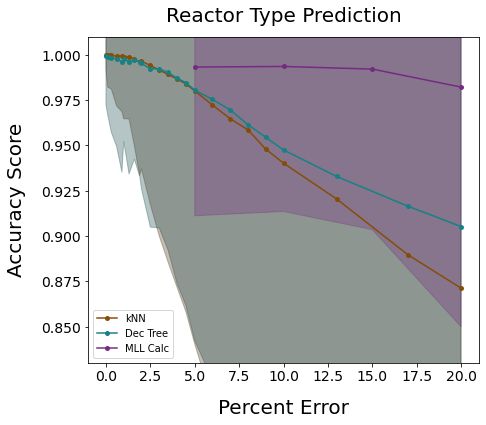

In [65]:
plot_curves('Reactor Type Prediction')

## Burnup

<Figure size 432x288 with 0 Axes>

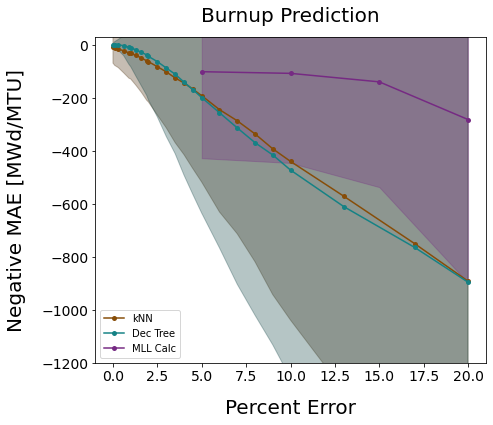

In [66]:
plot_curves('Burnup Prediction')

## Enrichment

<Figure size 432x288 with 0 Axes>

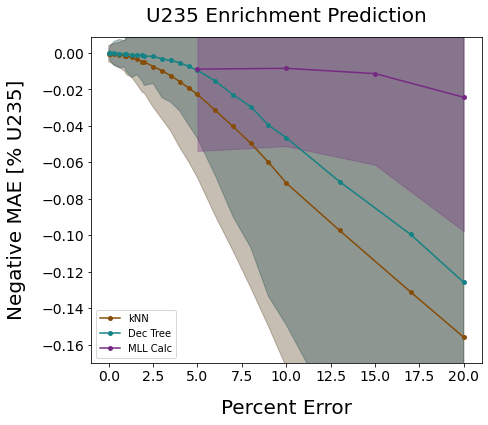

In [67]:
plot_curves('U235 Enrichment Prediction')

## Time Since Irraditation

<Figure size 432x288 with 0 Axes>

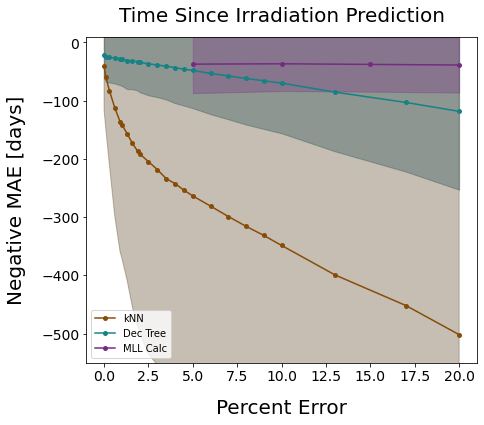

In [68]:
plot_curves('Time Since Irradiation Prediction')